# Exploratory Data Analysis

### Metadata Exploratory Data Analysis

We carried out a few intial tasks to explore and better understand the data, its consistency, to find any irregularities and try to visualize 


In [ ]:
import import_ipynb
from data603 import HDFS

httpdfs = HDFS.get_httpdfs()
httpdfs.list('/data/keras_models')

['densenet',
 'efficientnet',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nasnet',
 'resnet',
 'vgg16',
 'vgg19',
 'xception']

In [ ]:
# Create a local directory
import os
keras_data = './keras_data'
if(not os.path.exists(keras_data)):
    os.mkdir(keras_data)

# download file from hdfs
mobilenet_weight_file = 'mobilenet_1_0_224_tf.h5'
local_weight_file = f"{keras_data}/{mobilenet_weight_file}"
if(not os.path.exists(local_weight_file)):
    httpdfs.download(f"/data/keras_models/mobilenet/{mobilenet_weight_file}", local_weight_file)

# check local file exists
os.listdir(keras_data)

['vgg16_weights_tf_dim_ordering_tf_kernels.h5',
 '.ipynb_checkpoints',
 'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
 'mobilenet_1_0_224_tf.h5']

In [ ]:
import import_ipynb
from data603 import SparkLauncher

# get a configuration object
conf = SparkLauncher.get_spark_conf()

# add a file to the configuration that will get copied to all the nodes on the cluster
conf.set('spark.yarn.dist.files', './keras_data/mobilenet_1_0_224_tf.h5')

# launch the cluster using the configuration
spark = SparkLauncher.get_spark_session(pack_venv = True, conf = conf)

importing Jupyter notebook from /scratch/data603/a280/data603/SparkLauncher.ipynb
Creating Spark Configuration
Creating Spark Configuration
Packing Virtual Environment: a280.tar.gz
Setting Environment Variables
Creating Spark Session: a280_data603_spark_session


In [ ]:
class_descr = spark.read.csv('/data/google_open_image/metadata/class-descriptions-boxable.csv',header=False)

In [ ]:
class_descr = class_descr.withColumnRenamed("_c0", "LabelName").withColumnRenamed("_c1", "LabelText")

In [ ]:
class_descr.limit(2).show()

+-----------+---------+
|  LabelName|LabelText|
+-----------+---------+
|  /m/011k07| Tortoise|
|/m/011q46kg|Container|
+-----------+---------+



We checked for null values and data consistency.

In [ ]:
class_descr.filter("LabelText is null").count()

0

In [ ]:
class_descr.select(class_descr['LabelText']).distinct().count()

601

In [ ]:
from pyspark.sql.types import *
label_schema = StructType([
    StructField("ImageID", StringType()),
    StructField("Source", StringType()),
    StructField("LabelName", StringType()),
    StructField("Confidence", DoubleType())
])
labels = spark.read.csv('/data/google_open_image/labels/*.csv',header = True,schema = label_schema)

In [ ]:
labels.show(5)

+----------------+------------+---------+----------+
|         ImageID|      Source|LabelName|Confidence|
+----------------+------------+---------+----------+
|000002b66c9c498e|verification|/m/014j1m|       0.0|
|000002b66c9c498e|verification|/m/014sv8|       1.0|
|000002b66c9c498e|verification| /m/01599|       0.0|
|000002b66c9c498e|verification| /m/015p6|       0.0|
|000002b66c9c498e|verification|/m/015x4r|       0.0|
+----------------+------------+---------+----------+
only showing top 5 rows



In [ ]:
image_ids = labels.filter("Confidence > 0.99").select("ImageID").distinct()

In [ ]:
import pyspark.sql.functions as F
images_parquet = spark.read.parquet('/etl/google_open_image/images_coalesced.parquet')
images_parquet = images_parquet.select(['ImageID', 'Subset', 'Data'])\
                .withColumn("ImageID", F.lower(F.col('ImageID')))

In [ ]:
images_parquet = image_ids.join(images_parquet, on = 'ImageID', how = 'left')

In [ ]:
bounding_boxes_1 = spark.read.csv('/data/google_open_image/bboxes/test-annotations-bbox.csv', header = True)
bounding_boxes_2 = spark.read.csv('/data/google_open_image/bboxes/train-annotations-bbox.csv', header = True)
bounding_boxes_3 = spark.read.csv('/data/google_open_image/bboxes/validation-annotations-bbox.csv', header = True)

In [ ]:
bounding_boxes_1.show(2)

+----------------+------+---------+----------+---------+---------+----------+----------+----------+-----------+---------+-----------+--------+
|         ImageID|Source|LabelName|Confidence|     XMin|     XMax|      YMin|      YMax|IsOccluded|IsTruncated|IsGroupOf|IsDepiction|IsInside|
+----------------+------+---------+----------+---------+---------+----------+----------+----------+-----------+---------+-----------+--------+
|000026e7ee790996|xclick| /m/07j7r|         1| 0.071875|0.1453125|   0.20625|0.39166668|         0|          1|        1|          0|       0|
|000026e7ee790996|xclick| /m/07j7r|         1|0.4390625| 0.571875|0.26458332|0.43541667|         0|          1|        1|          0|       0|
+----------------+------+---------+----------+---------+---------+----------+----------+----------+-----------+---------+-----------+--------+
only showing top 2 rows



To check differences among the test, train and validation data, we counted the number of images in each subset which had a confidence greater than 0.99. 

Number of images in test 

In [ ]:
bounding_boxes_1.count()

937327

Number of distinct images in test set having confidence greater than 0.99

In [ ]:
bounding_boxes_1.filter('Confidence > 0.99').distinct().count()

937327

The numbers match for test set.

Number of images in train set.

In [ ]:
bounding_boxes_2.count()

14610229

Number of distinct images in train set having confidence greater than 0.99

In [ ]:
bounding_boxes_2.filter('Confidence > 0.99').distinct().count()

14609671

**We observe a difference** in the numbers. This is one difference we found between the 3 data subsets.

Number of images in validation set.

In [ ]:
bounding_boxes_3.count()

303980

Number of distinct images in validation set having confidence greater than 0.99.

In [ ]:
bounding_boxes_3.filter('Confidence > 0.99').distinct().count()

303980

In [ ]:
bounding_boxes = bounding_boxes_1.union(bounding_boxes_2).union(bounding_boxes_3)

In [ ]:
bounding_boxes.columns

['ImageID',
 'Source',
 'LabelName',
 'Confidence',
 'XMin',
 'XMax',
 'YMin',
 'YMax',
 'IsOccluded',
 'IsTruncated',
 'IsGroupOf',
 'IsDepiction',
 'IsInside']

In [ ]:
bounding_boxes.show(10)

+----------------+------+---------+----------+-----------+----------+----------+-----------+----------+-----------+---------+-----------+--------+
|         ImageID|Source|LabelName|Confidence|       XMin|      XMax|      YMin|       YMax|IsOccluded|IsTruncated|IsGroupOf|IsDepiction|IsInside|
+----------------+------+---------+----------+-----------+----------+----------+-----------+----------+-----------+---------+-----------+--------+
|000026e7ee790996|xclick| /m/07j7r|         1|   0.071875| 0.1453125|   0.20625| 0.39166668|         0|          1|        1|          0|       0|
|000026e7ee790996|xclick| /m/07j7r|         1|  0.4390625|  0.571875|0.26458332| 0.43541667|         0|          1|        1|          0|       0|
|000026e7ee790996|xclick| /m/07j7r|         1|    0.66875|         1|         0|  0.5520833|         0|          1|        1|          0|       0|
|000062a39995e348|xclick| /m/015p6|         1| 0.20620842|  0.849224|0.15463917|          1|         0|          0|   

In [ ]:
bounding_boxes.select('ImageID').count()

15851536

## To find number of bounding boxes per image.

In [ ]:
bounding_boxes.groupby('ImageID').count().sort('count',ascending=False).show(10)

+----------------+-----+
|         ImageID|count|
+----------------+-----+
|55558de0ee48ecf6|  745|
|51eac5c6e03db094|  697|
|7d501a419bcd4908|  621|
|fe5029b0fa7a6073|  620|
|9ba50cb2198a23d8|  560|
|6d9e9b98df51edca|  553|
|7c88895aadef1f0c|  543|
|058fd2f7c3fa5bf9|  541|
|daa5d98515e5d123|  531|
|05b0aefc92880a6c|  516|
+----------------+-----+
only showing top 10 rows



We explored files in metadata.

In [ ]:
hdfs= HDFS.get_hdfs()
hdfs.ls('/data/google_open_image')

['/data/google_open_image/bboxes',
 '/data/google_open_image/ids',
 '/data/google_open_image/images',
 '/data/google_open_image/labels',
 '/data/google_open_image/masks',
 '/data/google_open_image/metadata',
 '/data/google_open_image/relationships',
 '/data/google_open_image/segmentations']

In [ ]:
hdfs.ls('/data/google_open_image/metadata')

['/data/google_open_image/metadata/attributes-description.csv',
 '/data/google_open_image/metadata/class-descriptions-boxable.csv',
 '/data/google_open_image/metadata/classes-segmentation.txt',
 '/data/google_open_image/metadata/relationship-triplets.csv',
 '/data/google_open_image/metadata/relationships-description.csv']

In [ ]:
attri=spark.read.csv('/data/google_open_image/metadata/attributes-description.csv')

In [ ]:
attri.show(5)

+---------+----------------+
|      _c0|             _c1|
+---------+----------------+
|/m/02gy9n|     Transparent|
| /m/05z87|         Plastic|
| /m/0dnr7|(made of)Textile|
| /m/04lbp|(made of)Leather|
| /m/083vt|          Wooden|
+---------+----------------+



In [ ]:
rel_trip=spark.read.csv('/data/google_open_image/metadata/relationship-triplets.csv')

In [ ]:
rel_trip.show(5)

+----------+----------+-----------------+
|       _c0|       _c1|              _c2|
+----------+----------+-----------------+
|LabelName1|LabelName2|RelationshipLabel|
|  /m/01599| /m/04bcr3|               on|
| /m/05r655|/m/0h8my_4|            holds|
| /m/05r655|  /m/03k3r|               on|
|  /m/04yx4| /m/0l14j_|            holds|
+----------+----------+-----------------+
only showing top 5 rows



In [ ]:
rel_descr=spark.read.csv('/data/google_open_image/metadata/relationships-description.csv')

In [ ]:
rel_descr.show(5)

+--------------+--------------+
|           _c0|           _c1|
+--------------+--------------+
|            at|            at|
|            on|   on (top of)|
|         holds|         holds|
|         plays|         plays|
|interacts_with|interacts with|
+--------------+--------------+
only showing top 5 rows



Reading the images file.

In [ ]:
images= spark.read.parquet('/etl/google_open_image/images.parquet')

In [ ]:
images.show(5)

+----------------+------+------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+------------+--------------------+--------------------+--------+
|         ImageID|Subset|Format|                Data|         OriginalURL|  OriginalLandingURL|             License|    AuthorProfileURL|         Author|               Title|OriginalSize|         OriginalMD5|    Thumbnail300KURL|Rotation|
+----------------+------+------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+------------+--------------------+--------------------+--------+
|0000d59fa570d973| train|   JPG|[FF D8 FF E0 00 1...|https://farm4.sta...|https://www.flick...|https://creativec...|https://www.flick...|Shkumbin Saneja|  James Blunt Tour 5|      778226|nPqr5Ngx1hTYH381e...|https://c6.static...|     0.0|
|000213f8efef7523| train|   JPG|[FF D8 FF E0

### Joining dataframes based on ImageID of each column.

In [ ]:
final_df= labels.join(class_descr, on=['LabelName'], how='outer')
final_df=final_df.join(images, on=['ImageID'], how='outer')

To visualize the Labeltext data in the dataframe, we used **groupby** to get the number of instances of each LabelText and sorted them in a descending order. 

In [ ]:
lab=final_df.groupby('LabelText').count().sort('count',ascending=False).limit(40)

In [ ]:
lab=lab.toPandas()

In [ ]:
lab

,LabelText,count
0,Person,892037
1,Clothing,720911
2,Man,492675
3,Plant,486300
4,Tree,458747
5,Human face,410061
6,Woman,393642
7,Girl,299439
8,Vehicle,283084
9,Building,272843


## Visualizing the labels based on the number of times they occur in the data 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

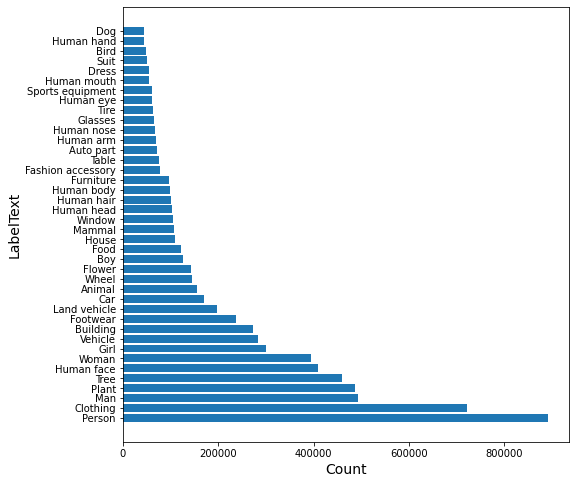

In [ ]:
plt.barh(lab['LabelText'],lab['count'])
fig=plt.gcf()
fig.set_size_inches(8,8)
_=plt.ylabel('LabelText',fontsize=14)
_=plt.xlabel('Count',fontsize=14)

In [ ]:
hdfs.ls('/data/google_open_image/segmentations')

['/data/google_open_image/segmentations/test-annotations-object-segmentation.csv',
 '/data/google_open_image/segmentations/train-annotations-object-segmentation.csv',
 '/data/google_open_image/segmentations/validation-annotations-object-segmentation.csv']

In [ ]:
seg=spark.read.csv('/data/google_open_image/segmentations/*.csv',header=True)

In [ ]:
seg.show(5)

+--------------------+----------------+----------+--------+--------+--------+--------+--------+------------+--------------------+
|            MaskPath|         ImageID| LabelName|   BoxID| BoxXMin| BoxXMax| BoxYMin| BoxYMax|PredictedIoU|              Clicks|
+--------------------+----------------+----------+--------+--------+--------+--------+--------+------------+--------------------+
|677c122b0eaa5d16_...|677c122b0eaa5d16|  /m/04yx4|9a041d52|  0.8875|0.960938|0.454167|0.720833|     0.86864|0.95498 0.65197 1...|
|05529ae018130c68_...|05529ae018130c68|  /m/09j2d|b1115fd0|0.086875|0.254375|0.504708| 0.79096|      0.8025|0.16388 0.50114 1...|
|96e7ee70b428a54e_...|96e7ee70b428a54e|  /m/04yx4|05580497| 0.45625|0.603125|0.222013|0.903104|      0.5585|0.52271 0.46625 0...|
|76084f166740d78a_...|76084f166740d78a|  /m/09j2d|557dfcf5| 0.01875|0.145625|0.313333|0.754167|     0.62394|0.08756 0.34082 0...|
|ebaccfc70c721055_...|ebaccfc70c721055|/m/02p0tk3|b39109c0|  0.0975|  0.2125|0.291667|0.93

We tried exploring the different categories and sub-categories in the data using the **bbox_labels** file.

In [ ]:
import json
with open('bbox_labels.json') as json_file:
    data = json.load(json_file)

In [ ]:
data

{'LabelName': '/m/0bl9f',
 'Subcategory': [{'LabelName': '/m/0242l'},
  {'LabelName': '/m/03120'},
  {'LabelName': '/m/0h8l4fh'},
  {'LabelName': '/m/0138tl',
   'Subcategory': [{'LabelName': '/m/0167gd'},
    {'LabelName': '/m/01j51'},
    {'LabelName': '/m/029b3'},
    {'LabelName': '/m/02wmf'},
    {'LabelName': '/m/02zt3'},
    {'LabelName': '/m/0kmg4'}]},
  {'LabelName': '/m/019dx1',
   'Subcategory': [{'LabelName': '/m/0174k2'},
    {'LabelName': '/m/01k6s3'},
    {'LabelName': '/m/029bxz'},
    {'LabelName': '/m/02pjr4'},
    {'LabelName': '/m/02wv84t'},
    {'LabelName': '/m/02x984l'},
    {'LabelName': '/m/03qhv5'},
    {'LabelName': '/m/03s_tn'},
    {'LabelName': '/m/03wvsk'},
    {'LabelName': '/m/040b_t'},
    {'LabelName': '/m/04169hn'},
    {'LabelName': '/m/04lvq_'},
    {'LabelName': '/m/063rgb'},
    {'LabelName': '/m/07xyvk'},
    {'LabelName': '/m/0fx9l'},
    {'LabelName': '/m/0ky7b'},
    {'LabelName': '/m/0llzx'},
    {'LabelName': '/m/0c3m8g'},
    {'LabelName':